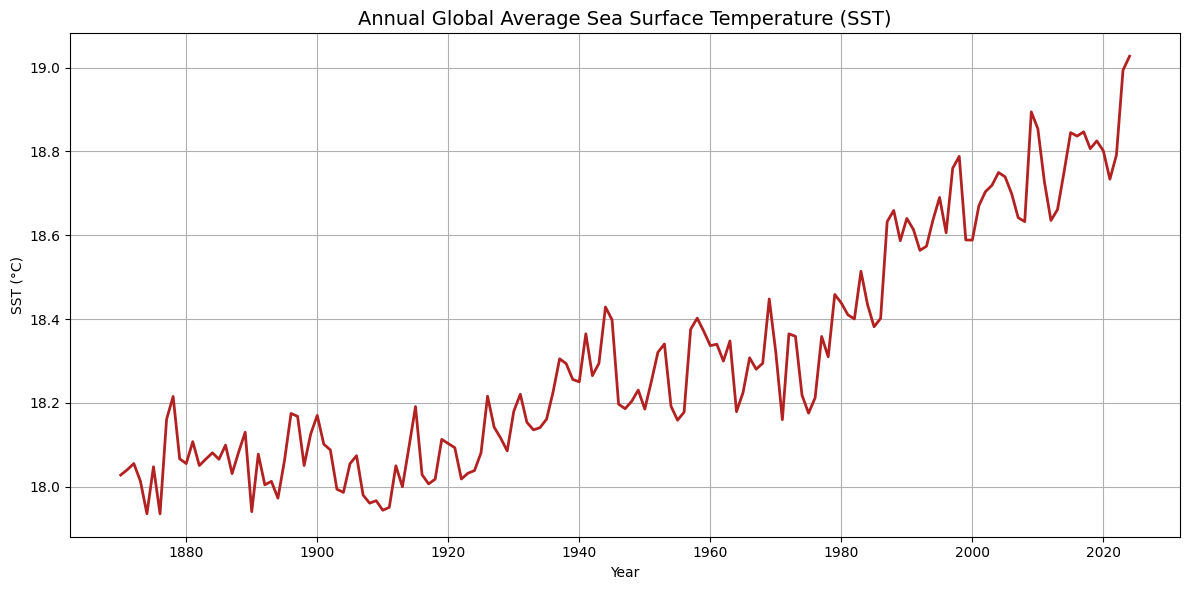

In [ ]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

file_path = '/Users/yutanzhang/Desktop/SST/HadISST_sst.nc'
ds = nc.Dataset(file_path)

sst_raw = ds.variables['sst'][:]
lat = ds.variables['latitude'][:]
lon = ds.variables['longitude'][:]
time = ds.variables['time']
time_units = time.units
calendar = getattr(time, 'calendar', 'standard')

dates_raw = nc.num2date(time[:], units=time_units, calendar=calendar)
dates = np.array([datetime(d.year, d.month, d.day) for d in dates_raw])
years = np.array([d.year for d in dates])

fill_value = getattr(ds.variables['sst'], '_FillValue', 1e20)
sst = np.ma.masked_where((sst_raw == fill_value) | (sst_raw > 1e10) | (sst_raw < -10), sst_raw)

deg_to_rad = np.pi / 180.0
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')  # (lat, lon)
lat_abs = np.abs(lat_grid)
weights = (np.sin((lat_abs + 0.5) * deg_to_rad) - np.sin((lat_abs - 0.5) * deg_to_rad)) / 720

global_sst_monthly = np.empty(sst.shape[0])
for t in range(sst.shape[0]):
    sst_t = sst[t, :, :]
    w_t = np.ma.array(weights, mask=sst_t.mask)
    if np.sum(~w_t.mask) < 10:
        global_sst_monthly[t] = np.nan
    else:
        w_t /= np.sum(w_t)
        global_sst_monthly[t] = np.ma.average(sst_t, weights=w_t)

unique_years = np.arange(years.min(), years.max() + 1)
global_sst_annual = []

for y in unique_years:
    mask = (years == y) & ~np.isnan(global_sst_monthly)
    if np.sum(mask) >= 6:  # Require at least 6 valid months for a reliable year
        yearly_avg = np.nanmean(global_sst_monthly[mask])
    else:
        yearly_avg = np.nan
    global_sst_annual.append(yearly_avg)

global_sst_annual = np.array(global_sst_annual)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(unique_years, global_sst_annual, color='firebrick', linewidth=2)
ax.set_title('Annual Global Average Sea Surface Temperature (SST)', fontsize=14)
ax.set_xlabel('Year')
ax.set_ylabel('SST (°C)')
ax.grid(True)
plt.tight_layout()
plt.show()

ds.close()